This notebook makes use MITgcm and TPXO tidal amplitude and phase outputs.

The first part let us plot the tidal amplitude and phase maps, as well as the differences between the MITgcm and TPXO.

The second part is dedicated to the computation of the spatially averaged RMS.

In [1]:
import numpy as np
import xarray as xr
import os
from xmitgcm import open_mdsdataset
from os.path import expanduser,join,isdir
import sys
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py as ecco
from matplotlib.lines import Line2D
import ecco_v4_py
import warnings

warnings.filterwarnings(
    "ignore", 
    category=FutureWarning, 
    message=".*decode_timedelta will default to False.*"
)

In [3]:
#This xarray will never be used (and the ETAN data contains only 1point).
#The only goal is to later extract the XC and YC coordinates, and use them in the other xarrays.

#Their is probably a smarter way 
data_dir ='../../scripts/ETAN_1point'
grid_dir ='../../scripts/grid_1deg'
ds_llc = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN_hourly'},
                         geometry="llc") #non-native grid


# Maps from MITgcm outputs

In [5]:
# The MITgcm outputs are stored in 13 tiles that we want to rearange and convert in a latitude-longitude frame.
# File path pattern
CLIM = False
if CLIM: 
    file_pattern = "../../scripts/maps_mitgcm_5years_clim/amp_consts_{}.txt"
    file_phase = "../../scripts/maps_mitgcm_5years_clim/pha_consts_{}.txt"
else : 
    file_pattern = "../../scripts/maps_mitgcm_5years_noclim/amp_consts_{}.txt"
    file_phase = "../../scripts/maps_mitgcm_5years_noclim/pha_consts_{}.txt"
n_tiles = 13
amp_data, phase_data = [],[]
#List of the tidal constituents which have been fitted to the sea level map
constit_labels= ['M2', 'S2', 'N2', 'K2','K1', 'O1', 'P1', 'Q1', 'Mm', 'Mf', 'M4', 'Mn4', 'Ms4', '2N2']

#Choose the number of the tidal constituent to plot, following the order of constit_labels.
TIDAL_CONSTITUENT=0

#AMPLITUDE 
#For a given constituent, open the 13 tiles and stack them in an array with shape (tile,i,j) 
for tile in range(n_tiles):
    filename = file_pattern.format(tile)
    # Load the 90x90 array
    data = np.loadtxt(filename)
    nx, ny = 90, 90 
    n_constituents = data.shape[0]
    amp_3d = data.reshape(n_constituents, nx, ny)
    amp_data.append(amp_3d[TIDAL_CONSTITUENT,:,:])
    

#PHASE 
for tile in range(n_tiles):
    filename = file_phase.format(tile)
    # Load the 90x90 array
    pha_data = np.loadtxt(filename)
    nx, ny = 90, 90 
    # Reshape to 3D
    n_constituents = pha_data.shape[0]
    pha_3d = pha_data.reshape(n_constituents, nx, ny)
    phase_data.append(pha_3d[TIDAL_CONSTITUENT,:,:])


# To compare MITgcm maps with  TPXO, we need to convert them from (tile,i,j) to (lat,lon) coordinates.
#Import the lat and long coordinates from the original xarray
XC = ds_llc['XC'].data
YC = ds_llc['YC'].data

# Create xarrays for amplitude and phase.
ds_amp = xr.DataArray(
    np.array(amp_data),
    dims=["tile", "i", "j"],
    coords={
        "tile": np.arange(n_tiles),
        "i": np.arange(90),
        "j": np.arange(90),
        "XC": (["tile", "i", "j"], XC),
        "YC": (["tile", "i", "j"], YC)
    },
    name="amplitude"
)
ds_pha = xr.DataArray(
    np.array(phase_data),
    dims=["tile", "i", "j"],
    coords={
        "tile": np.arange(n_tiles),
        "i": np.arange(90),
        "j": np.arange(90),
        "XC": (["tile", "i", "j"], XC),
        "YC": (["tile", "i", "j"], YC)
    },
    name="phase"
)
#Interpolate the previous xarrays from XC,YC to the same 1deg (lat,long) coordinates than TPXO data.
new_grid_delta_lat = 1 
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90
#This definition of the longitude (-180,180) is the default one used by the function ecco.resample_to_latlon
new_grid_min_lon = -180
new_grid_max_lon = 180

ds_lat_lon_amp = ecco.resample_to_latlon(ds_amp.XC, 
                                ds_amp.YC, 
                                ds_amp.where(ds_pha!=0),
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.nan, 
                                mapping_method = 'nearest_neighbor',
                                    )

ds_lat_lon_phase = ecco.resample_to_latlon(ds_pha.XC, 
                                ds_pha.YC, 
                                ds_pha.where(ds_pha!=0),
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.nan, 
                                mapping_method = 'nearest_neighbor',
                                    )



### Amplitude map

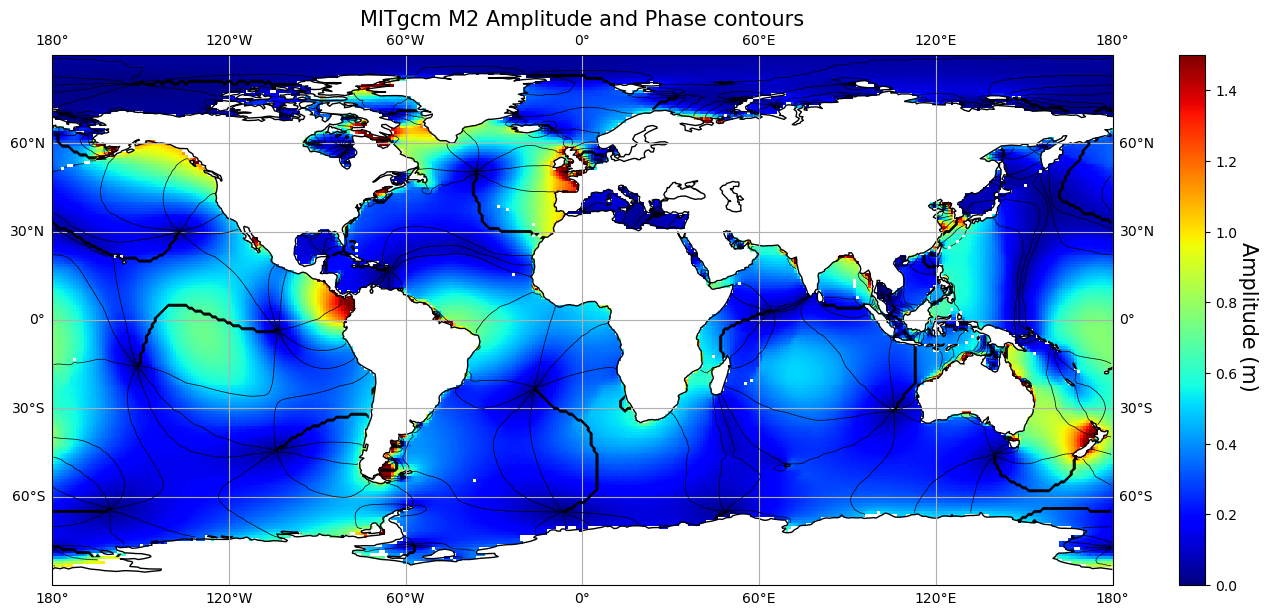

In [6]:

#Coordinates of the center of the cells  (180,360)
longitude_center = ds_lat_lon_amp[0]  
latitude_center = ds_lat_lon_amp[1]  
#Coordinates of the edges of the cell
longitude_edge = ds_lat_lon_amp[2]
latitude_edge = ds_lat_lon_amp[3]
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())


pcm = ax.pcolormesh(longitude_edge, latitude_edge,ds_lat_lon_amp[4],
                cmap='jet', shading='auto',
                       vmax = 1.5,
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()
ax.gridlines(draw_labels=True)

ax.contour(longitude_center, latitude_center, ds_lat_lon_phase[4], levels = np.arange(0, 361, 45), colors='k',linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'Amplitude (m) ',  rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm '+ constit_labels[TIDAL_CONSTITUENT]+' Amplitude and Phase contours',fontsize=15)
plt.tight_layout()
plt.show()


### Phase map

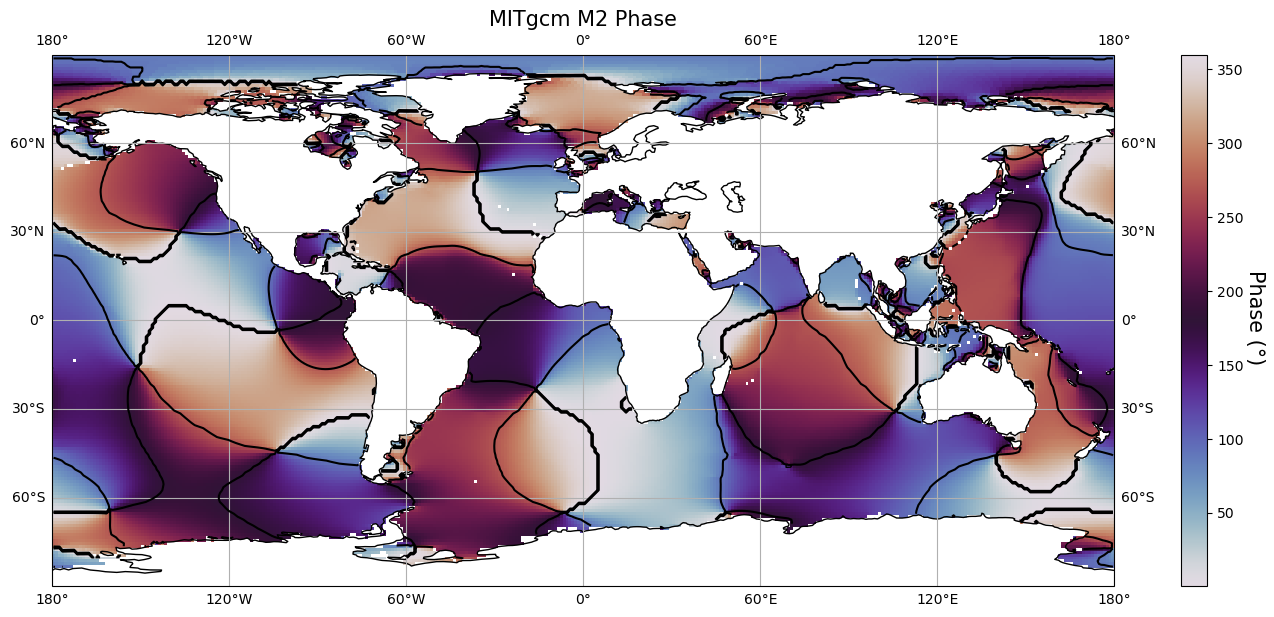

In [7]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# The 'twilight' colorbar highlights the cyclical values of the phase.
pcm = ax.pcolormesh(longitude_edge, latitude_edge,ds_lat_lon_phase[4],#ds_lat_lon[4] ,#- amp_map,
                    cmap='twilight', shading='auto', 
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()
ax.gridlines(draw_labels=True)

ax.contour(longitude_center, latitude_center, ds_lat_lon_phase[4], levels = np.arange(0, 361, 90), colors='k')#,width=0.2)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'Phase (°) ',  rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm '+ constit_labels[TIDAL_CONSTITUENT]+' Phase',fontsize=15)
plt.tight_layout()

plt.show()

# Maps from TPXO outputs

### Amplitude Map

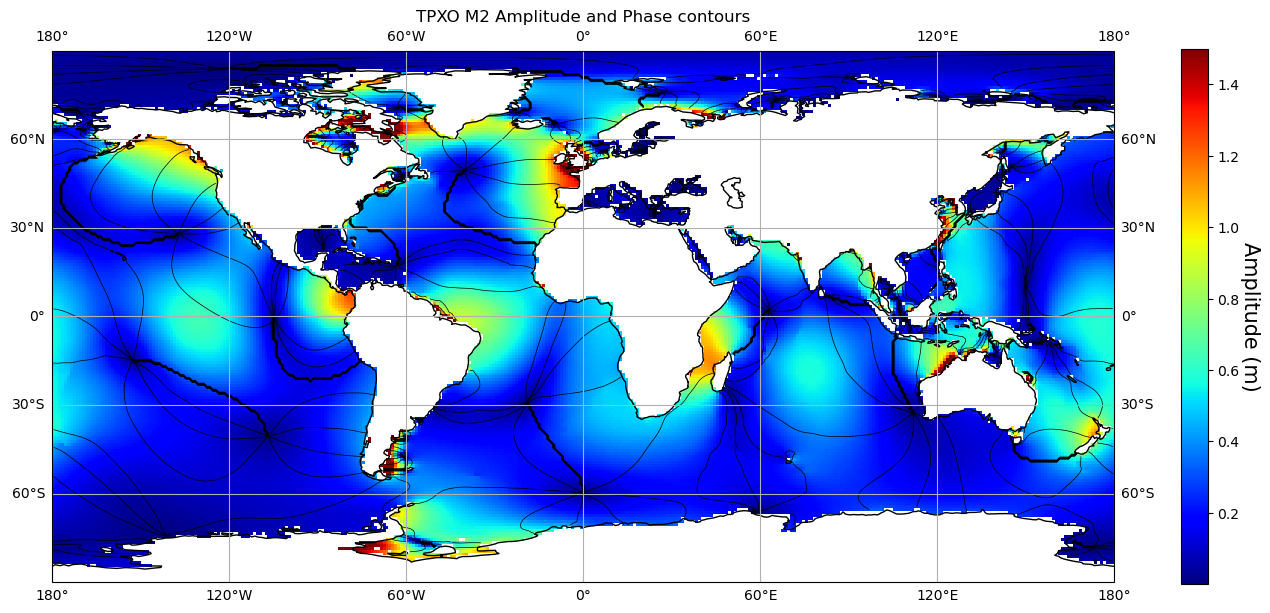

In [8]:
constituents = ['m2', 's2', 'n2', 'k2','k1', 'o1', 'p1', 'q1', 'mm', 'mf', 'm4', 'mn4', 'ms4', '2n2']
amp_map= np.loadtxt('../../scripts/maps_tpxo_long_180/ampli_ll_txpo_'+constituents[TIDAL_CONSTITUENT]+'.txt')
ph_map= np.loadtxt('../../scripts/maps_tpxo_long_180/ph_ll_txpo_'+constituents[TIDAL_CONSTITUENT]+'.txt')

#The land cells in TPXO amplitude and phase maps have a 1e20 value, we replace them with nans
ph_map[ph_map>1e19] = np.nan 
amp_map[amp_map>1e19] = np.nan


fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())


pcm = ax.pcolormesh(longitude_edge, latitude_edge, amp_map,
                    cmap='jet', shading='auto',
                    transform=ccrs.PlateCarree(),vmax = 1.5)

# Add coastlines and features
ax.coastlines()
ax.contour(longitude_center, latitude_center, ph_map, levels = np.arange(0, 361, 45), colors='k',linewidths=0.5)

ax.gridlines(draw_labels=True)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label('Amplitude (m)',rotation = 270,labelpad = 15,fontsize=15)

plt.title('TPXO ' + constit_labels[TIDAL_CONSTITUENT]+' Amplitude and Phase contours')
plt.tight_layout()
#plt.savefig('./Plots/ampli_M2_TPXO.pdf',bbox_inches='tight')
plt.show()

# Phase map

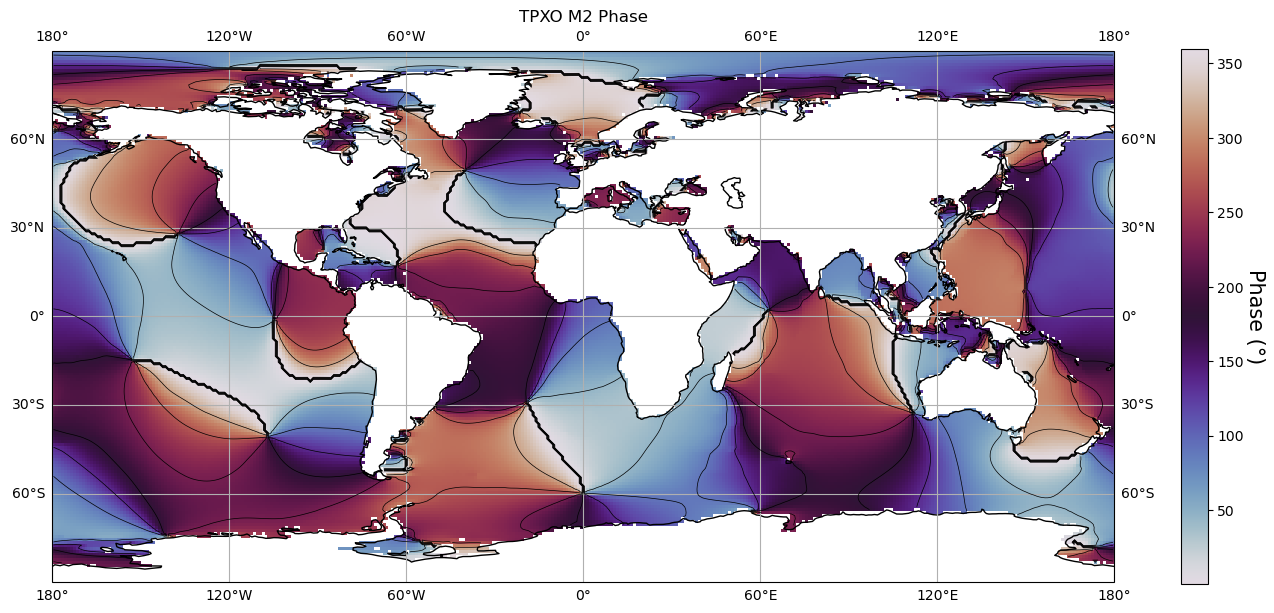

In [9]:

fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

pcm = ax.pcolormesh(longitude_edge, latitude_edge, ph_map,
                    cmap='twilight', shading='auto',
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.contour(longitude_center, latitude_center, ph_map, levels = np.arange(0, 361, 45), colors='k',linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label('Phase (°)',rotation = 270,labelpad = 15,fontsize=15)

plt.title('TPXO ' + constit_labels[TIDAL_CONSTITUENT]+' Phase')
plt.tight_layout()
#plt.savefig('./Plots/ampli_M2_TPXO.pdf',bbox_inches='tight')
plt.show()

# Map differences

# Amplitude

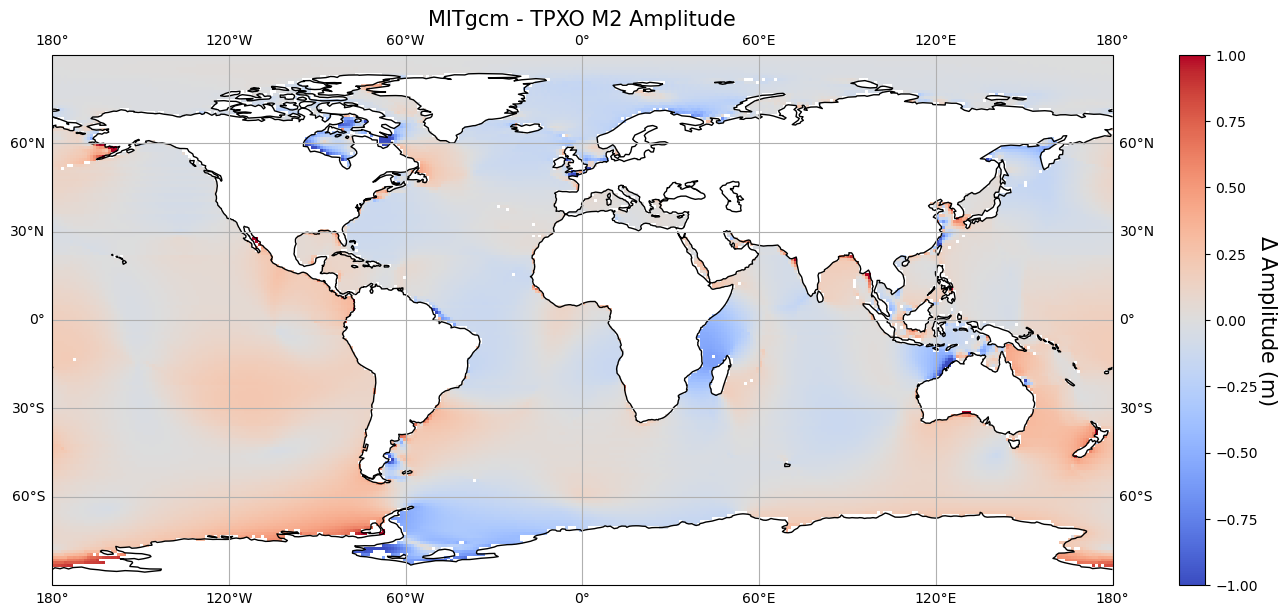

In [10]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot amplitude using pcolormesh
pcm = ax.pcolormesh(longitude_edge, latitude_edge,ds_lat_lon_amp[4] - amp_map,#ds_lat_lon[4] ,#- amp_map,
                    cmap='coolwarm', shading='auto',
                    vmax = 1., vmin = -1.,
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'$\Delta$ Amplitude (m)', rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm - TPXO '+constit_labels[TIDAL_CONSTITUENT]+' Amplitude',fontsize=15)
plt.tight_layout()

plt.show()

## Phase 

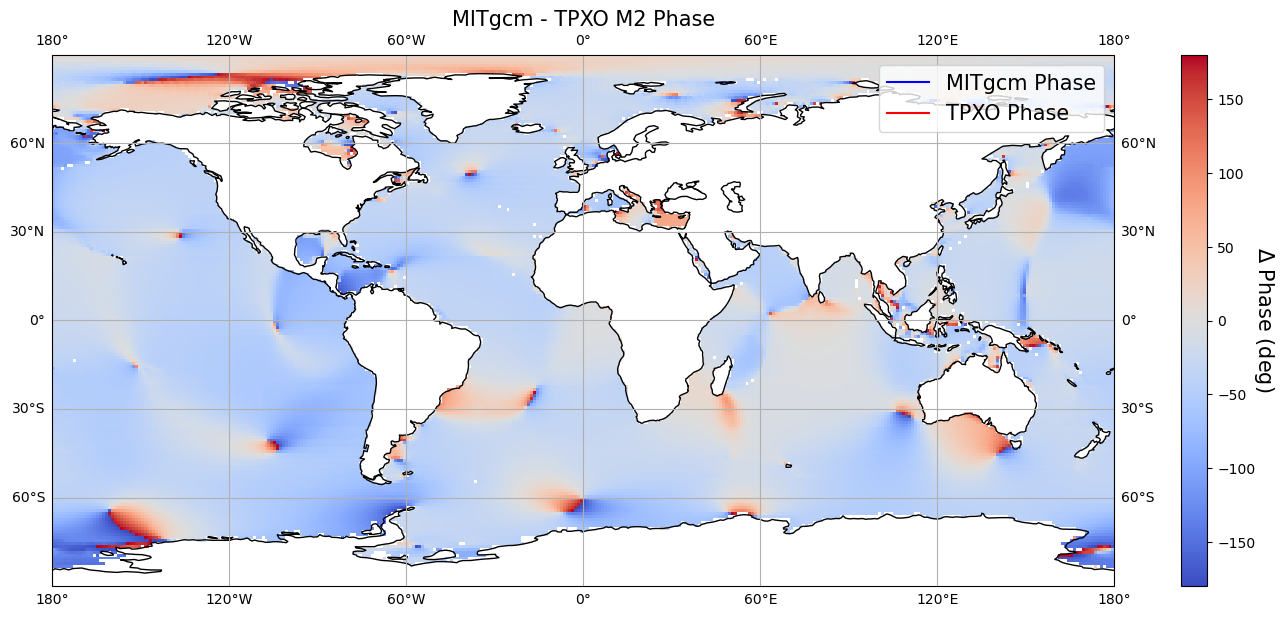

In [11]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Modulate the phase difference between 0 (in phase) and 180 (out of phase)
phase_diff = (ds_lat_lon_phase[4] - ph_map + 180) % 360 - 180

pcm = ax.pcolormesh(longitude_edge, latitude_edge, phase_diff, #ds_lat_lon_phase[4] - ph_sorted,#ds_lat_lon[4] ,#- amp_map,
                    cmap='coolwarm', shading='auto',
                    transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

legend_lines = [
    Line2D([0], [0], color='blue', label='MITgcm Phase'),
    Line2D([0], [0], color='red', label='TPXO Phase')
]
ax.legend(handles=legend_lines, loc='upper right',fontsize =15) 

cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'$\Delta$ Phase (deg) ',  rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm - TPXO '+constit_labels[TIDAL_CONSTITUENT]+' Phase',fontsize=15)
plt.tight_layout()
plt.show()


# Computation of spatially averaged Root Mean Square 

In [12]:

# Spatially averaged Amplitude RMS of mitGCM and tpxo
RMSAmitgcm = 1e2*np.sqrt(np.nanmean(((ds_lat_lon_amp[4])*np.cos(latitude_center))**2))
RMSAtpxo= 1e2*np.sqrt(np.nanmean(((amp_map)*np.cos(latitude_center))**2))

# Spatially averages Amplitude RMS difference  (mitgcm-tpxo), 
RMSAdiff= 1e2*np.sqrt(np.nanmean(((ds_lat_lon_amp[4]-amp_map)*np.cos(latitude_center))**2))

#Spatially averages Phase RMS difference  (mitgcm-tpxo)
RMSPdiff= np.sqrt(np.nanmean(((phase_diff)*np.cos(latitude_center))**2))

print('Constituent: ', constit_labels[TIDAL_CONSTITUENT])
print('RMS MITgcm Amplitude:',round(RMSAmitgcm,4),'cm')
print('RMS TPXO Amplitude:',round(RMSAtpxo,4),'cm')

print('RMS diff  MITgcm - TPXO Amplitude:',round(RMSAdiff,4),'cm')
print('RMS diff MITgcm - TPXO Phase:',round(RMSPdiff,4), '°')

# % of explained variance, to assess how close is our simulation with respect to TPXO, 
print('% of explained amplitude variance:', round(1e2*(1-(RMSAdiff/RMSAtpxo)**2),4), '%')

Constituent:  M2
RMS MITgcm Amplitude: 28.248 cm
RMS TPXO Amplitude: 28.6431 cm
RMS diff  MITgcm - TPXO Amplitude: 11.1219 cm
RMS diff MITgcm - TPXO Phase: 34.4833 °
% of explained amplitude variance: 84.9228 %
